In [1]:
%matplotlib inline
%reset
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import scipy

import SchemDraw as schem # to draw schematics (install using 'pip install SchemDraw')
import SchemDraw.elements as e

import skrf as rf # scikit-rf (install using 'conda -c scikit-rf scikit-rf')

import sympy as s # sympy (install using 'conda -c sympy sympy')
from sympy import I # imaginary symbol
from sympy.simplify.fu import fu, TR7

rf.stylely() # enable scikit-rf plot styles
s.init_printing(use_latex='mathjax') # print sympy equations in MathJAX (for Jupyter)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
def mag2db(mag):
    return np.multiply(20.0, np.log10(mag))
def mag2pdb(mag):
    return np.multiply(10.0, np.log10(mag))
def db2mag(db):
    return np.power(10, np.divide(db, 20.0))
def pdb2mag(pdb):
    return np.power(10, np.divide(pdb, 10.0))
def rad2deg(rad):
    return np.multiply(np.divide(rad, (2*np.pi)), 360.0)
def deg2rad(deg):
    return np.multiply(np.divide(deg, 360.0), 2*np.pi)
def dbm2v(dbm, R = 50):
    # P = V^2 / R
    power = 1e-3 * np.power(10, np.divide(dbm, 10))
    return np.sqrt(power * (R*2))    
def v2dbm(v, R = 50):
    power = np.divide(np.power(v, 2), R*2)
    return 10 * np.log10(power/1e-3)

In [7]:
# Single tone harmonic distortion
A, w1, t = s.symbols('A \omega_1 t', real=True)
a1, a2, a3 = s.symbols('a_1 a_2 a_3')
Si = A * s.cos(w1*t)
display(Si)
So = a1*Si + a2*(Si**2) + a3*(Si**3)
So = s.expand(s.fu(So, measure=lambda x: -x.count_ops()))
display(So)
print(s.latex(So))

A⋅cos(\omega₁⋅t)

   3                      3                        2                        2 
3⋅A ⋅a₃⋅cos(\omega₁⋅t)   A ⋅a₃⋅cos(3⋅\omega₁⋅t)   A ⋅a₂⋅cos(2⋅\omega₁⋅t)   A ⋅
────────────────────── + ────────────────────── + ────────────────────── + ───
          4                        4                        2                2

                        
a₂                      
── + A⋅a₁⋅cos(\omega₁⋅t)
                        

\frac{3 a_{3}}{4} A^{3} \cos{\left (\omega_1 t \right )} + \frac{A^{3} a_{3}}{4} \cos{\left (3 \omega_1 t \right )} + \frac{A^{2} a_{2}}{2} \cos{\left (2 \omega_1 t \right )} + \frac{A^{2} a_{2}}{2} + A a_{1} \cos{\left (\omega_1 t \right )}


In [6]:
# Two tone harmonic distortion
A, w1, w2, t = s.symbols('A \omega_1 \omega_2 t', real=True)
a1, a2, a3 = s.symbols('a_1 a_2 a_3')
Si = A * s.cos(w1*t) + A * s.cos(w2*t)
display(Si)
So = a1*Si + a2*(Si**2) + a3*(Si**3)
So = s.expand(s.fu(So, measure=lambda x: -x.count_ops()))
display(So)
print(s.latex(Si))
print(s.latex(So))

A⋅cos(\omega₁⋅t) + A⋅cos(\omega₂⋅t)

   3                      3                          3                      3 
9⋅A ⋅a₃⋅cos(\omega₁⋅t)   A ⋅a₃⋅cos(3⋅\omega₁⋅t)   9⋅A ⋅a₃⋅cos(\omega₂⋅t)   A ⋅
────────────────────── + ────────────────────── + ────────────────────── + ───
          4                        4                        4                 

                         3                                      3             
a₃⋅cos(3⋅\omega₂⋅t)   3⋅A ⋅a₃⋅cos(\omega₁⋅t - 2⋅\omega₂⋅t)   3⋅A ⋅a₃⋅cos(\omeg
─────────────────── + ──────────────────────────────────── + ─────────────────
       4                               4                                      

                         3                                      3             
a₁⋅t + 2⋅\omega₂⋅t)   3⋅A ⋅a₃⋅cos(2⋅\omega₁⋅t - \omega₂⋅t)   3⋅A ⋅a₃⋅cos(2⋅\om
─────────────────── + ──────────────────────────────────── + ─────────────────
4                                      4                                      

                       2                        2

A \cos{\left (\omega_1 t \right )} + A \cos{\left (\omega_2 t \right )}
\frac{9 a_{3}}{4} A^{3} \cos{\left (\omega_1 t \right )} + \frac{A^{3} a_{3}}{4} \cos{\left (3 \omega_1 t \right )} + \frac{9 a_{3}}{4} A^{3} \cos{\left (\omega_2 t \right )} + \frac{A^{3} a_{3}}{4} \cos{\left (3 \omega_2 t \right )} + \frac{3 a_{3}}{4} A^{3} \cos{\left (\omega_1 t - 2 \omega_2 t \right )} + \frac{3 a_{3}}{4} A^{3} \cos{\left (\omega_1 t + 2 \omega_2 t \right )} + \frac{3 a_{3}}{4} A^{3} \cos{\left (2 \omega_1 t - \omega_2 t \right )} + \frac{3 a_{3}}{4} A^{3} \cos{\left (2 \omega_1 t + \omega_2 t \right )} + \frac{A^{2} a_{2}}{2} \cos{\left (2 \omega_1 t \right )} + \frac{A^{2} a_{2}}{2} \cos{\left (2 \omega_2 t \right )} + A^{2} a_{2} \cos{\left (\omega_1 t - \omega_2 t \right )} + A^{2} a_{2} \cos{\left (\omega_1 t + \omega_2 t \right )} + A^{2} a_{2} + A a_{1} \cos{\left (\omega_1 t \right )} + A a_{1} \cos{\left (\omega_2 t \right )}


In [12]:
# Problem 1a
10**(db2mag(-3) / 20.0) - 1

0.0849189356218

In [13]:
# Blocker apparent gain effect (w1 = blocker, w2 = desired, A = blocker amplitude, B = desired amplitude)
# Problem 1b
A, B, w1, w2, t = s.symbols('A B \omega_1 \omega_2 t', real=True)
a1, a2, a3 = s.symbols('a_1 a_2 a_3')
Si = A * s.cos(w1*t) + B * s.cos(w2*t)
display(Si)
So = a1*Si + a2*(Si**2) + a3*(Si**3)
So = s.expand(s.fu(So, measure=lambda x: -x.count_ops()))
display(So)
print(s.latex(Si))
print(s.latex(So))

A⋅cos(\omega₁⋅t) + B⋅cos(\omega₂⋅t)

   3                      3                          2                        
3⋅A ⋅a₃⋅cos(\omega₁⋅t)   A ⋅a₃⋅cos(3⋅\omega₁⋅t)   3⋅A ⋅B⋅a₃⋅cos(\omega₂⋅t)   3
────────────────────── + ────────────────────── + ──────────────────────── + ─
          4                        4                         2                

  2                                        2                                  
⋅A ⋅B⋅a₃⋅cos(2⋅\omega₁⋅t - \omega₂⋅t)   3⋅A ⋅B⋅a₃⋅cos(2⋅\omega₁⋅t + \omega₂⋅t)
───────────────────────────────────── + ──────────────────────────────────────
                 4                                        4                   

    2                        2           2                          2         
   A ⋅a₂⋅cos(2⋅\omega₁⋅t)   A ⋅a₂   3⋅A⋅B ⋅a₃⋅cos(\omega₁⋅t)   3⋅A⋅B ⋅a₃⋅cos(\
 + ────────────────────── + ───── + ──────────────────────── + ───────────────
             2                2                2                              

                               2                 

A \cos{\left (\omega_1 t \right )} + B \cos{\left (\omega_2 t \right )}
\frac{3 a_{3}}{4} A^{3} \cos{\left (\omega_1 t \right )} + \frac{A^{3} a_{3}}{4} \cos{\left (3 \omega_1 t \right )} + \frac{3 a_{3}}{2} A^{2} B \cos{\left (\omega_2 t \right )} + \frac{3 a_{3}}{4} A^{2} B \cos{\left (2 \omega_1 t - \omega_2 t \right )} + \frac{3 a_{3}}{4} A^{2} B \cos{\left (2 \omega_1 t + \omega_2 t \right )} + \frac{A^{2} a_{2}}{2} \cos{\left (2 \omega_1 t \right )} + \frac{A^{2} a_{2}}{2} + \frac{3 a_{3}}{2} A B^{2} \cos{\left (\omega_1 t \right )} + \frac{3 a_{3}}{4} A B^{2} \cos{\left (\omega_1 t - 2 \omega_2 t \right )} + \frac{3 a_{3}}{4} A B^{2} \cos{\left (\omega_1 t + 2 \omega_2 t \right )} + A B a_{2} \cos{\left (\omega_1 t - \omega_2 t \right )} + A B a_{2} \cos{\left (\omega_1 t + \omega_2 t \right )} + A a_{1} \cos{\left (\omega_1 t \right )} + \frac{3 a_{3}}{4} B^{3} \cos{\left (\omega_2 t \right )} + \frac{B^{3} a_{3}}{4} \cos{\left (3 \omega_2 t \right )} + \frac{B^{2} a_{2}}{2} \c

In [15]:
temp = 10**(db2mag(-2)/20.0)-1
np.sqrt(temp/2 * (10**2))

2.18817783585

In [17]:
# Two-tone blocker apparent gain effect
# Problem 1b
A, B, wb1, wb2, wd, t = s.symbols('A B \omega_{b1} \omega_{b2} \omega_{d} t', real=True)
a1, a2, a3 = s.symbols('a_1 a_2 a_3')
Si = A * s.cos(wd*t) + B * s.cos(wb1*t) + B * s.cos(wb2*t)
display(Si)
So = a1*Si + a2*(Si**2) + a3*(Si**3)
So = s.expand(s.fu(So, measure=lambda x: -x.count_ops()))
#display(So)
#print(s.latex(Si))
#print(s.latex(So))

A⋅cos(\omega_{d}⋅t) + B⋅cos(\omega_{b1}⋅t) + B⋅cos(\omega_{b2}⋅t)

In [20]:
# Three-tone gain compression
# Problem 1d
A, w1, w2, w3, t = s.symbols('A \omega_1 \omega_2 \omega_3 t', real=True)
a1, a2, a3 = s.symbols('a_1 a_2 a_3')
Si = A * s.cos(w1*t) + A * s.cos(w2*t) + A * s.cos(w3*t)
display(Si)
So = a1*Si + a2*(Si**2) + a3*(Si**3)
So = s.expand(s.fu(So, measure=lambda x: -x.count_ops()))
display(So)

A⋅cos(\omega₁⋅t) + A⋅cos(\omega₂⋅t) + A⋅cos(\omega₃⋅t)

    3                      3                           3                      
15⋅A ⋅a₃⋅cos(\omega₁⋅t)   A ⋅a₃⋅cos(3⋅\omega₁⋅t)   15⋅A ⋅a₃⋅cos(\omega₂⋅t)   A
─────────────────────── + ────────────────────── + ─────────────────────── + ─
           4                        4                         4               

3                           3                      3                          
 ⋅a₃⋅cos(3⋅\omega₂⋅t)   15⋅A ⋅a₃⋅cos(\omega₃⋅t)   A ⋅a₃⋅cos(3⋅\omega₃⋅t)   3⋅A
───────────────────── + ─────────────────────── + ────────────────────── + ───
         4                         4                        4                 

3                                      3                                      
 ⋅a₃⋅cos(\omega₁⋅t - 2⋅\omega₂⋅t)   3⋅A ⋅a₃⋅cos(\omega₁⋅t + 2⋅\omega₂⋅t)   3⋅A
───────────────────────────────── + ──────────────────────────────────── + ───
              4                                      4                        

3                                      3         

In [22]:
# Problem 1d
IIP3 = 10
IP_one_tone = IIP3 * np.sqrt(0.11)
a1_over_a3 = (IIP3**2) * (3/4)
IP_two_tone = np.sqrt((4/9) * a1_over_a3) * np.sqrt(0.11)
IP_three_tone = np.sqrt((4/15) * a1_over_a3) * np.sqrt(0.11)
print(IP_one_tone, IP_two_tone, IP_three_tone)

3.31662479036 1.91485421551 1.48323969742


C:\Users\Vighnesh\Anaconda2\envs\py36\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


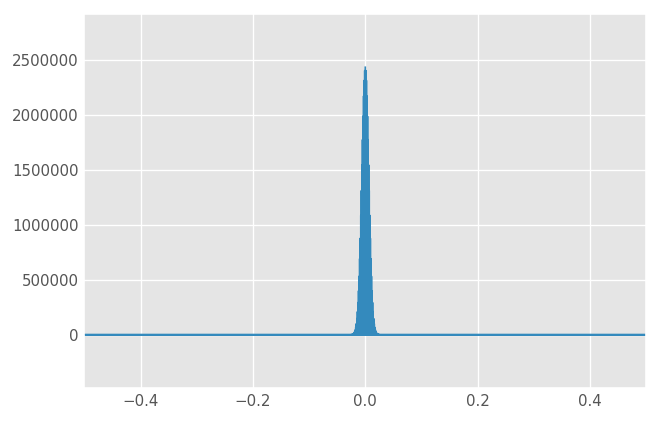

In [70]:
# Problem 1e
#Is, Vt, A, f, t, w = s.symbols('I_s V_t A f t \omega', real=True)
#I_out = Is * s.exp((A*s.cos(2*s.pi*t)) / Vt)
#display(I_out)
#s.fourier_transform(s.exp(s.cos(t)), t, w)
sample_points = np.arange(10000)
T = 1e-12 # sample period
A = 1
Vbe = A * np.cos(2 * np.pi * 1e9 * np.multiply(sample_points, T))
Vt = 25e-3
Is = 1.633E-14
I_out = Is * np.exp(np.divide(Vbe, Vt))
#plt.plot(I_out)
plt.plot(np.fft.fftfreq(sample_points.shape[-1]), np.fft.fft(I_out))